# Speed Line Modeling using Classical Optimization Techniques

## Overview

In this notebook, we perform experiments on the provided 3 Speed Line Datasets of the Marine Compressor. We make use of the following optimizers:
- *L-BFGS-B*
- *Powell*
- *TNC*
- *COBYLA*

These are evaluated using 3 different error metrics:
- *Ortho*
- *R2 Score*
- *Mean Absolute Error*

The code that follows, automates the process of execution on each possible combination of optimizer and error metric.

### Import Dependencies 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from operator import itemgetter
from tabulate import tabulate

from spotoptim.data.speedline_data import SpeedlineData
from spotoptim.preprocessing.speedlines import preprocess
from spotoptim.fit.single_fit import single_fit, update_model_coeff
from spotoptim.plot.speedplot import plot_speedline_fit, get_limits
from spotoptim.math.eval import analyze_optimization_results, evaluate_optimization_results
from spotoptim.models.llamas import llamas_m, llamas_pi

## User Defined Functions

### To get the number of iterations for each config:

In [ ]:
def get_niters(res):
    nit_values = {key: result["nit"] for key, result in res.items()}
    df = pd.DataFrame(nit_values.items(), columns = ['config', 'niters'])

    return df

### Calculates the overall Normalized RMSE for mass and pressure:

In [ ]:
def get_overall_rmse(sl_data, data_dict_name, res):
    x_values = {key: result["x"] for key, result in res.items()}

    measurements_preprocessed = sl_data.datadicts[data_dict_name]["measurements_preprocessed"]

    all_m_V = []
    all_m_V_hat = []
    all_Pi_tot_V = []
    all_Pi_tot_V_hat = []

    # Perform fit specialized for superelliptical datapoints on each speedline
    for speedline, group in measurements_preprocessed.groupby("Speedclass [m/s]"):
        m_V = np.array(group["m_V [kg/s]"])
        Pi_tot_V = np.array(group["Pi_tot_V [-]"])

        # Iterate over each beta value in the dictionary and compute errors
        if speedline in x_values:
            beta = x_values[speedline]
            Pi_tot_V_hat = llamas_pi(beta, m_V)
            m_V_hat = llamas_m(beta, Pi_tot_V)

            # Collect all values for overall RMSE calculation
            all_m_V.extend(m_V)
            all_m_V_hat.extend(m_V_hat)
            all_Pi_tot_V.extend(Pi_tot_V)
            all_Pi_tot_V_hat.extend(Pi_tot_V_hat)

    # Convert lists to NumPy arrays
    all_m_V = np.array(all_m_V)
    all_m_V_hat = np.array(all_m_V_hat)
    all_Pi_tot_V = np.array(all_Pi_tot_V)
    all_Pi_tot_V_hat = np.array(all_Pi_tot_V_hat)

    # Compute RMSE
    rmse_m_V = np.sqrt(np.mean((all_m_V - all_m_V_hat) ** 2))
    rmse_Pi_tot_V = np.sqrt(np.mean((all_Pi_tot_V - all_Pi_tot_V_hat) ** 2))

    # Normalize using the maximum of the predicted values
    norm_m_V = rmse_m_V / np.max(all_m_V_hat)
    norm_Pi_tot_V = rmse_Pi_tot_V / np.max(all_Pi_tot_V_hat)

    return norm_Pi_tot_V, norm_m_V

### Returns the speed line data and the corresponding results in a `dict`:

In [ ]:
def run_singlefit_opt(exp_name, df, opt_method, err_metric = 'ortho'):
    # Create a data object and store the data in it
    exp_data = {"measurements": df}
    sld = SpeedlineData(exp_name, exp_data)

    # Normalize the data
    sld = preprocess(sld, exp_name, method = "normalize")

    # Run the single fit method
    res = single_fit(sld, exp_name, method = opt_method, metric_name = err_metric)

    return sld, res

### Run the single fit and returns the results in test_result `dict`:

In [ ]:
def execute_optimization(data_opt_pairs, err_metric): 
    test_results = []

    for (exp_data, optimizer) in data_opt_pairs:

        print(f"Using {optimizer} optimizer on {exp_data} data.\n")

        df = pd.read_csv("data/"+ exp_data + ".csv")

        sld, res = run_singlefit_opt(exp_data, df, optimizer, err_metric)
        update_model_coeff(sl_data = sld, data_dict_name = exp_data, opt_results = res)
        
        # df_fun gets the value of error from res and stores it as a dataframe
        # df_stats stores the statistics related to the whole data for the particular optimization
        df_fun, df_stats = analyze_optimization_results(res)
        # Attach the number of iterations as a parameter to the dataframe

        if optimizer != 'COBYLA':
            df_iters = get_niters(res)
            df_fun = pd.merge(df_fun, df_iters, on = 'config')

        # df_err stores the error for each speed line
        # df_pi stores the error stats for Pi_tot_V
        # df_m stores the error stats for m_V
        df_err, df_pi, df_m = evaluate_optimization_results(sld, 
                                                            exp_data, 
                                                            res,
                                                            metric_name = "mean_squared_error")
        
        overall_norm_rmse_Pi, overall_norm_rmse_m = get_overall_rmse(sld, exp_data, res)

        test_results.append({"experiment_data": exp_data,
                             "optimizer": optimizer,
                             "sld": sld,
                             "df_fun": df_fun,
                             "df_stats": df_stats,
                             "df_err": df_err,
                             "df_pi": df_pi,
                             "df_m": df_m,
                             "overall_norm_rmse_Pi_tot_V": overall_norm_rmse_Pi,
                             "overall_norm_rmse_m_V": overall_norm_rmse_m,
                             "res": res
                            })
        
    return test_results

### Stores the Overall Normalized RMSE results for both mass and pressure for different optimizers and metrics:

In [14]:
def store_rmse_results(test_results, error_metric_name):
    df_dict = {}
    for test_result in test_results:
        experiment = test_result['experiment_data']
        optimizer = test_result['optimizer']
        
        overall_norm_rmse_Pi_tot_V = test_result['overall_norm_rmse_Pi_tot_V']
        overall_norm_rmse_m_V = test_result['overall_norm_rmse_m_V']

        df = pd.DataFrame({
            'optimizer': optimizer,
            'error_metric': error_metric_name,
            'overall_norm_rmse_Pi_tot_V': overall_norm_rmse_Pi_tot_V,
            'overall_norm_rmse_m_V': overall_norm_rmse_m_V,
        }, index = [0])

        if experiment in df_dict:
            df_dict[experiment] = pd.concat([df_dict[experiment], df], ignore_index = True)
        else:
            df_dict[experiment] = df

    return df_dict

## Functions for plotting:

### Plots the Speed Line Curves in 4 x 3 matrix: 

In [ ]:
def plot_sld(test_results, nrows = 4, ncols = 3, figsize = (25, 30)):
    # Sort the test results according to the optimizer
    results = sorted(test_results, key = itemgetter('optimizer'))

    fig, axs = plt.subplots(nrows, ncols, figsize = figsize)
    axs = axs.flatten()

    for i, res in enumerate(results):
        xmin, xmax, ymin, ymax = get_limits(res['sld'], res['experiment_data'], s = 0.3)

        plot_speedline_fit(sl_data = res['sld'], 
                        data_dict_name = res['experiment_data'], 
                        axs = axs[i],
                        xmin = xmin, 
                        xmax = xmax, 
                        ymin = ymin, 
                        ymax = ymax,
                        show = False)
        
        if 'error_metric' in res:
            text_str = f"Optimizer: {res['optimizer']} \n Error: {res['error_metric']}"
        else:
            text_str = f"Optimizer: {res['optimizer']}"
        
        axs[i].legend_.remove()
        axs[i].text(0.85, 
                    0.95, 
                    text_str, 
                    ha = "center", 
                    va = "center", 
                    fontsize = 12, 
                    weight = "bold", 
                    transform = axs[i].transAxes)  

    handles, labels = axs[0].get_legend_handles_labels()
    # Add a single legend to the entire figure
    fig.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0), fontsize = 10)
    fig.suptitle('Speed Line Plots', fontsize = 20, weight = 'bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

### Evaluation Plots (Compares number of iterations, error): 

In [ ]:
def plot_eval(exp_sorted_results, value, ylabel, plot_title, is_nit = False, keep_nelder = False):
    # Create a style guide for each optimizer
    # line_styles = {'L-BFGS-B': {'color': 'blue', 'marker': 'o', 'linestyle': '-'},
    #                'Powell': {'color': 'green', 'marker': 's', 'linestyle': '--'},
    #                'TNC': {'color': 'red', 'marker': '^', 'linestyle': '--'},
    #                'COBYLA': {'color': 'orange', 'marker': 'd', 'linestyle': ':'}}

    colors = {'L-BFGS-B': 'blue',
              'Powell': 'green',
              'TNC': 'red',
              'Nelder-Mead': 'orange'}

    # Create a subplot with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize = (20, 5))
    axs = axs.flatten()

    ind = 0
    ax = axs[ind]

    for i, result in enumerate(exp_sorted_results):
        # Change the subplot index after every 4 iterations
        if i % 4 == 0 and i != 0:
            ind += 1
            ax = axs[ind]

        if is_nit and result['optimizer'] == 'Nelder-Mead' and keep_nelder == False:
            continue

        df = result['df_fun']    
        x = np.arange(len(df['config']))
        width = 0.2

        opt_index = list(colors.keys()).index(result['optimizer'])
        ax.bar(x + width * opt_index, df[value], width, label = result['optimizer'], color = colors[result['optimizer']])
        
        ax.set_xticks(x)  # Set x-tick positions
        ax.set_xticklabels(df['config'], rotation = 90, ha = 'center', fontsize = 9)  # Set x-tick labels

        ax.set_xlabel('Speedline', fontsize = 10)
        ax.set_ylabel(ylabel, fontsize = 10)
        ax.set_title(result['experiment_data'])
        ax.grid(visible = True)

    plt.legend(loc="lower right", bbox_to_anchor = (1, 0), fontsize = 10)
    fig.suptitle(plot_title, fontsize = 15, weight = 'bold')
    plt.tight_layout(rect = [0, 0, 1, 0.95])


## Error Metric - Ortho

In [17]:
exp_data_list = ["experiment_4_0.321_0.1_15", 
                 "experiment_4_0.321_0.01_15",
                 "experiment_4_0.321_0.001_15"]

opt_method_list = ["L-BFGS-B",
                   "Powell",
                   "TNC",
                   "Nelder-Mead"]

# Get the cardinal product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

In [18]:
test_results = execute_optimization(data_opt_pairs, err_metric = "ortho")

Using L-BFGS-B optimizer on experiment_4_0.321_0.1_15 data.

Using Powell optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,


Using Nelder-Mead optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: ftol
  result = minimize(fun=residual_func,


Using L-BFGS-B optimizer on experiment_4_0.321_0.01_15 data.

Using Powell optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,


Using Nelder-Mead optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: ftol
  result = minimize(fun=residual_func,


Using L-BFGS-B optimizer on experiment_4_0.321_0.001_15 data.

Using Powell optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,


Using Nelder-Mead optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: ftol
  result = minimize(fun=residual_func,


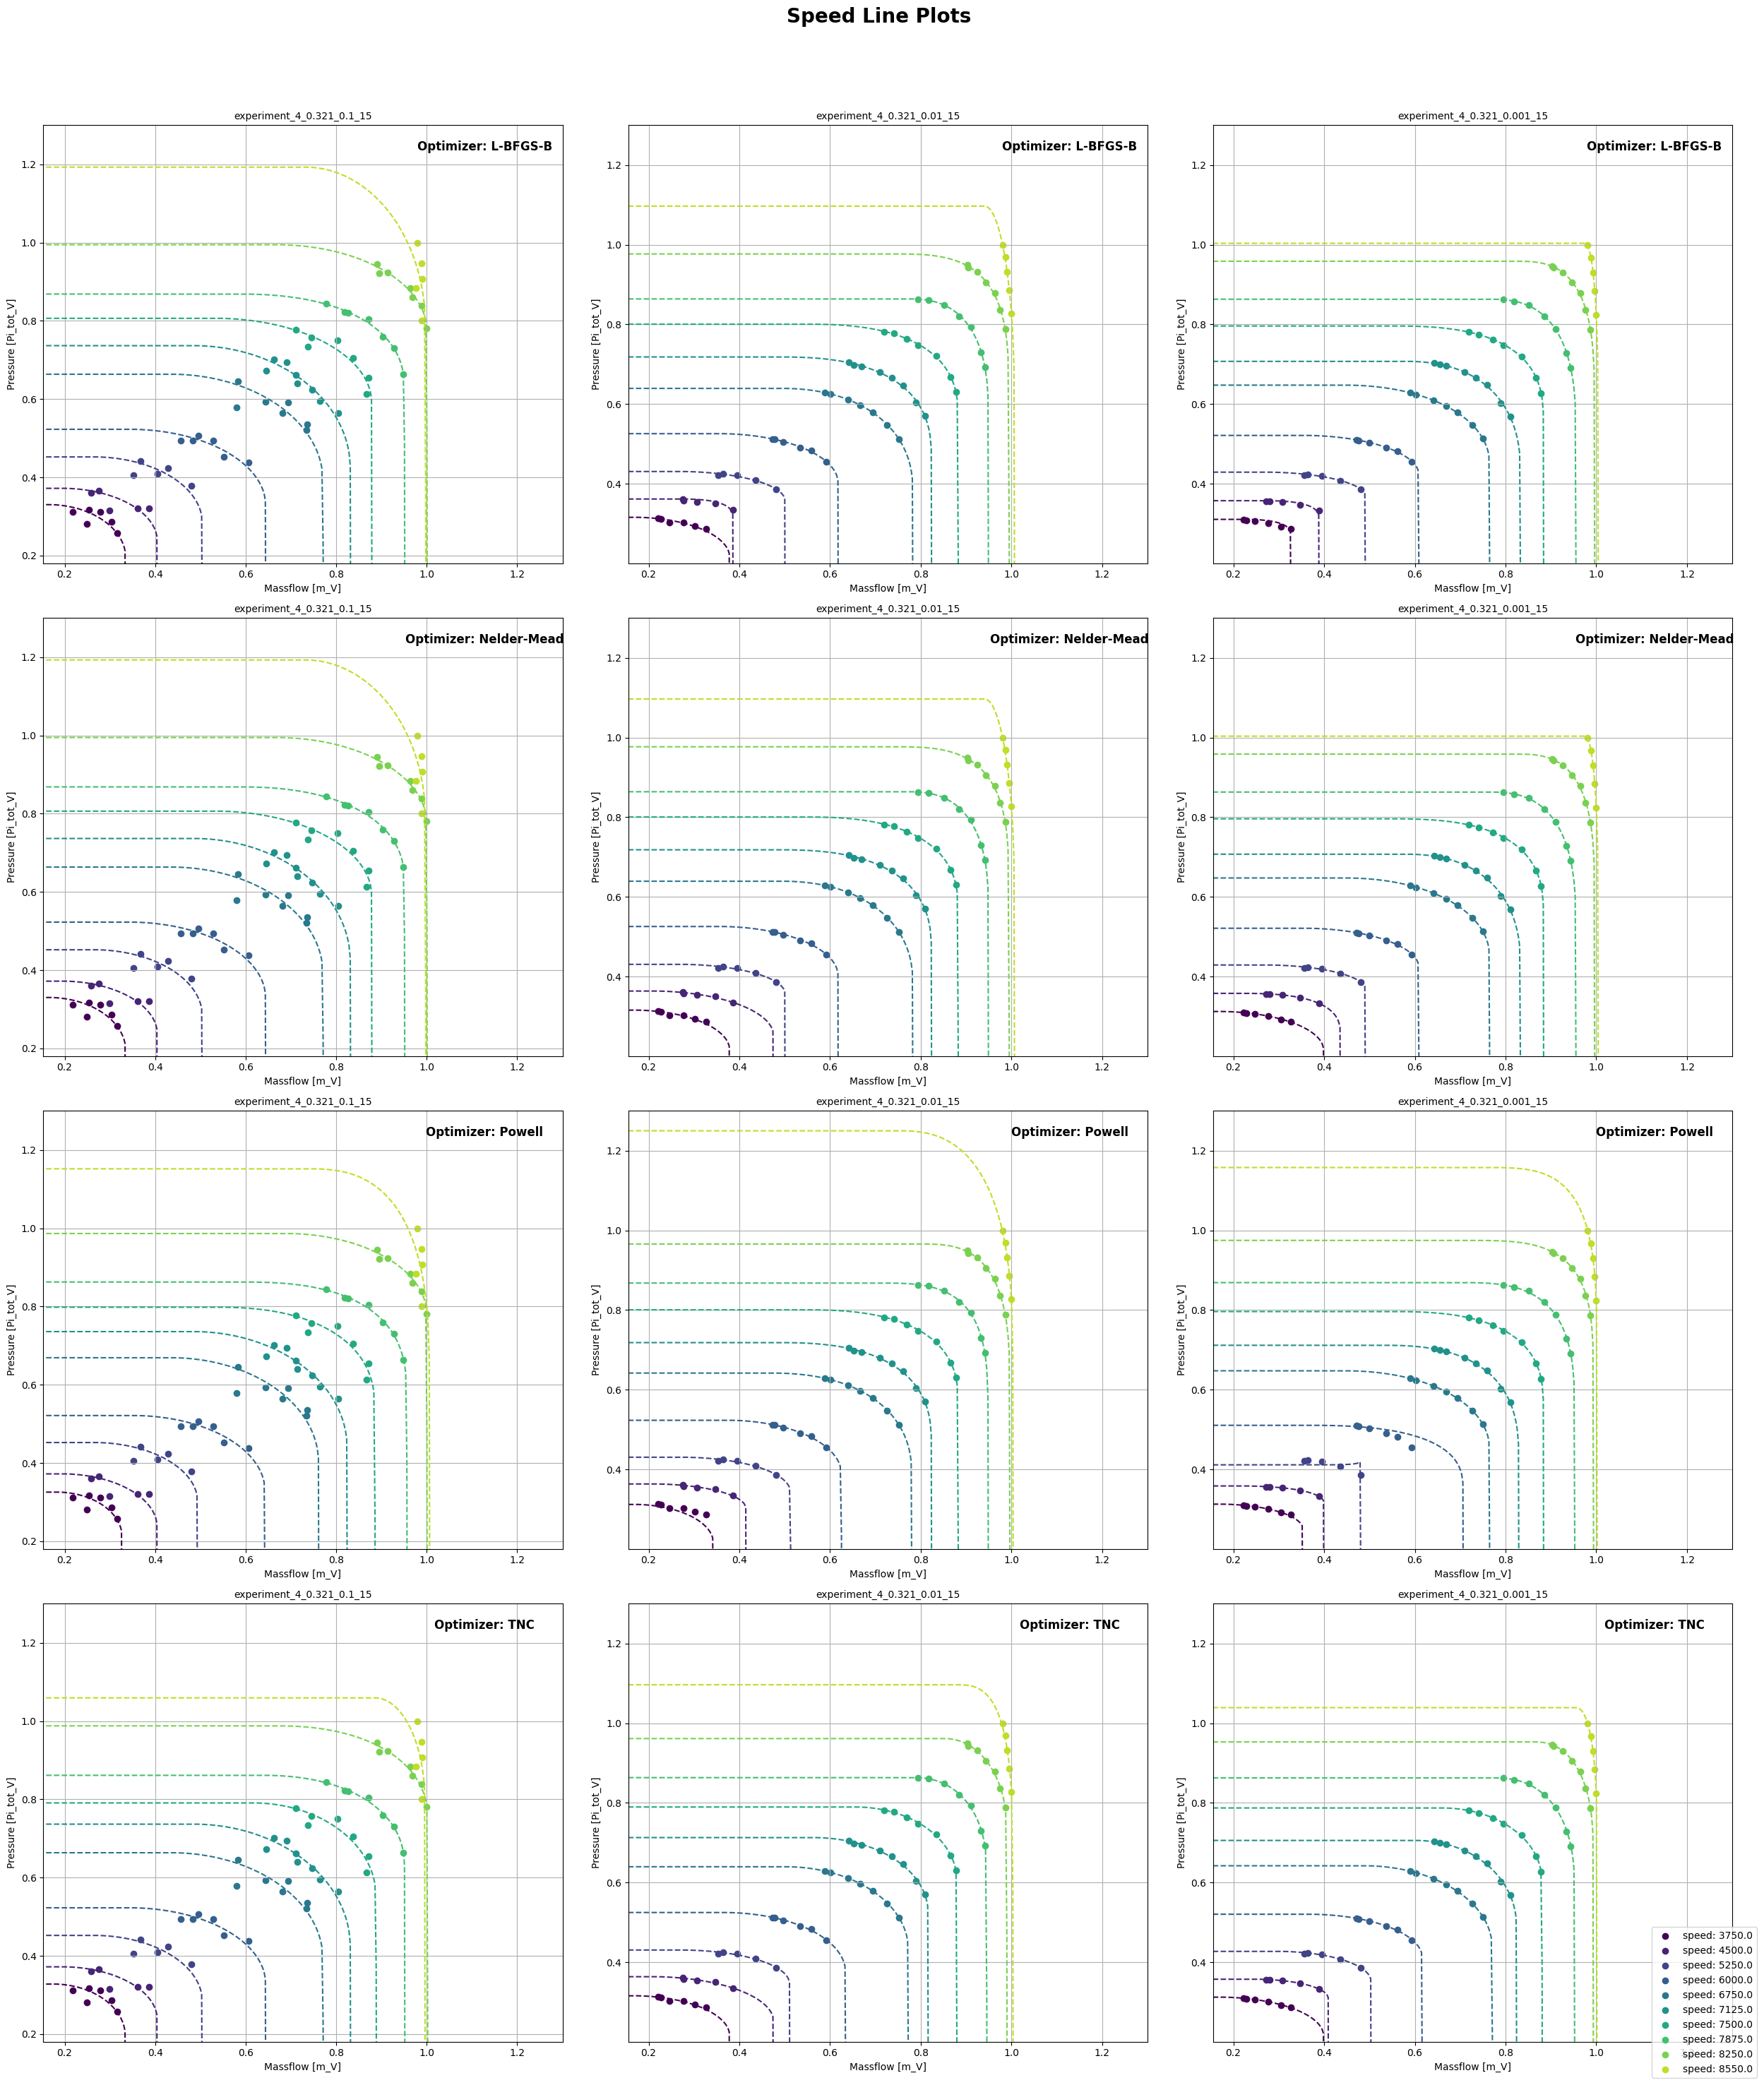

In [19]:
plot_sld(test_results)

plt.savefig('SpeedLinePlot-All-Optimizers-Ortho', dpi = 200)

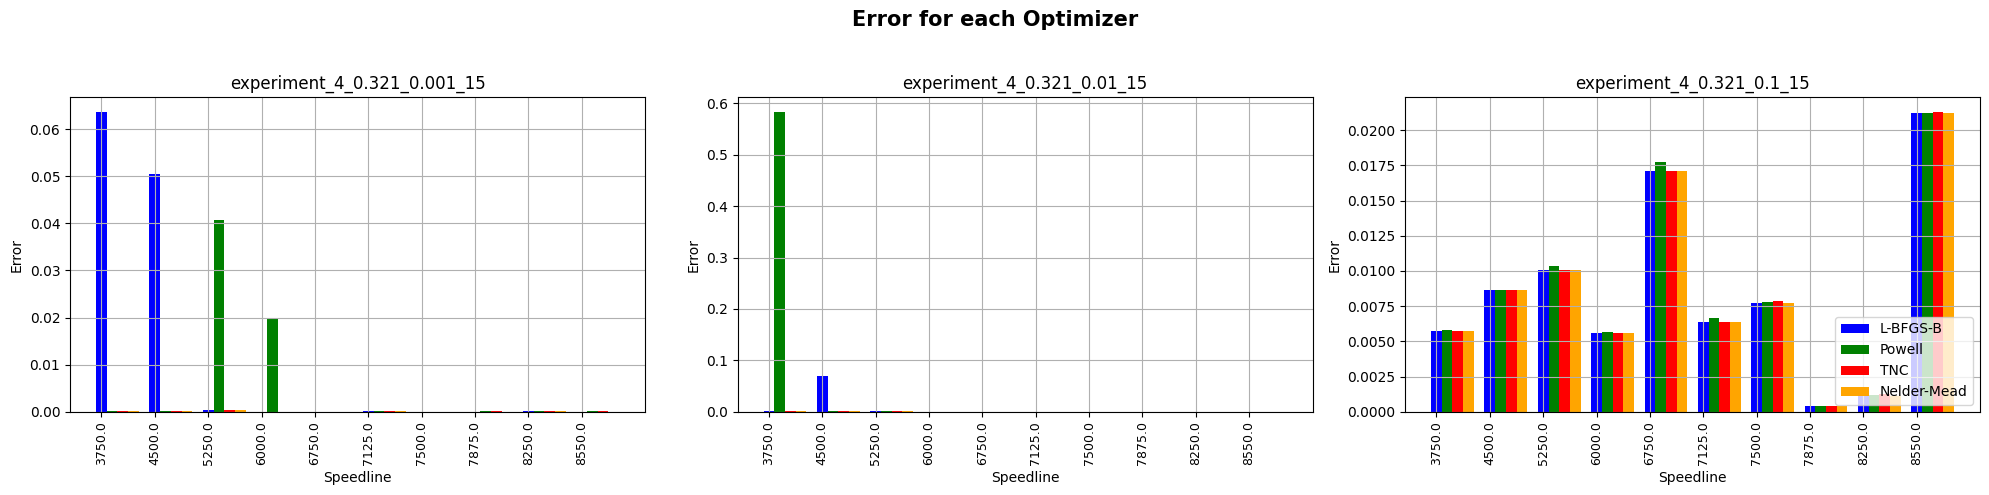

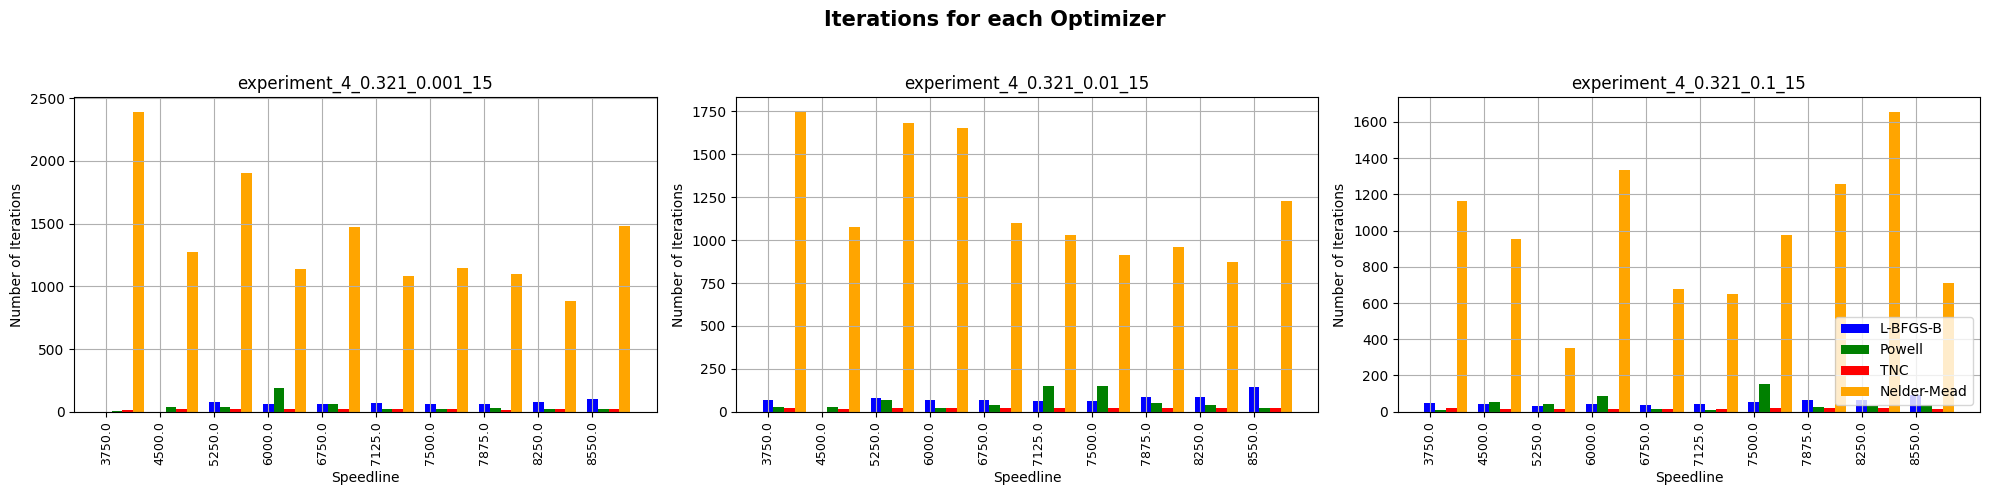

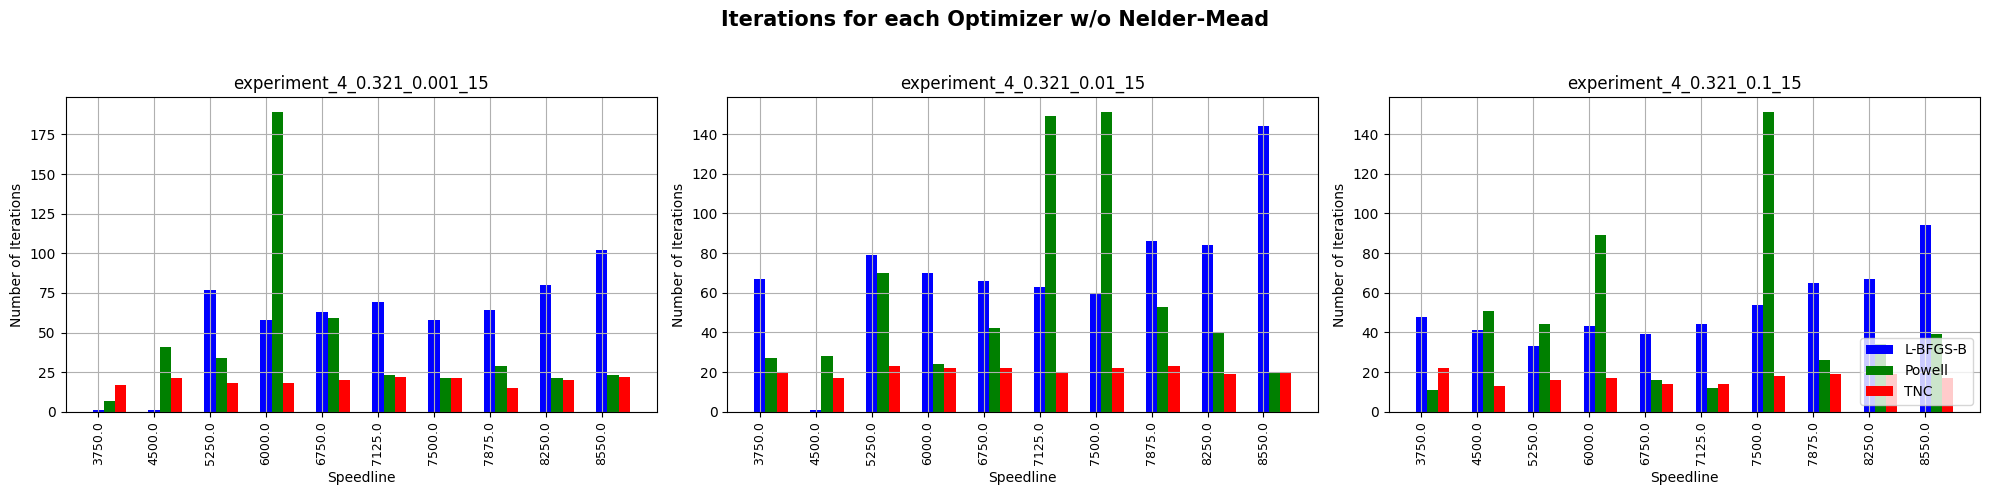

In [20]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results = sorted(test_results, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results, 
          value = 'error', 
          ylabel = 'Error', 
          plot_title = 'Error for each Optimizer')
plot_eval(exp_sorted_results,
          value = 'niters', 
          ylabel = 'Number of Iterations', 
          plot_title = 'Iterations for each Optimizer', 
          is_nit = True,
          keep_nelder = True)
plot_eval(exp_sorted_results,
          value = 'niters', 
          ylabel = 'Number of Iterations', 
          plot_title = 'Iterations for each Optimizer w/o Nelder-Mead', 
          is_nit = True,
          keep_nelder = False)

##  Error Metric - Mean Absolute Error

In [21]:
exp_data_list = ["experiment_4_0.321_0.1_15", 
                 "experiment_4_0.321_0.01_15",
                 "experiment_4_0.321_0.001_15"]

opt_method_list = ["L-BFGS-B",
                   "Powell",
                   "TNC",
                   "Nelder-Mead"]

# Get the cardinal product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

In [22]:
test_results_2 = execute_optimization(data_opt_pairs, err_metric = "mean_absolute_error")

Using L-BFGS-B optimizer on experiment_4_0.321_0.1_15 data.

Using Powell optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: Op

Using Nelder-Mead optimizer on experiment_4_0.321_0.1_15 data.

Using L-BFGS-B optimizer on experiment_4_0.321_0.01_15 data.

Using Powell optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: Op

Using Nelder-Mead optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: ftol
  result = minimize(fun=residual_func,


Using L-BFGS-B optimizer on experiment_4_0.321_0.001_15 data.

Using Powell optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: Op

Using Nelder-Mead optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: ftol
  result = minimize(fun=residual_func,


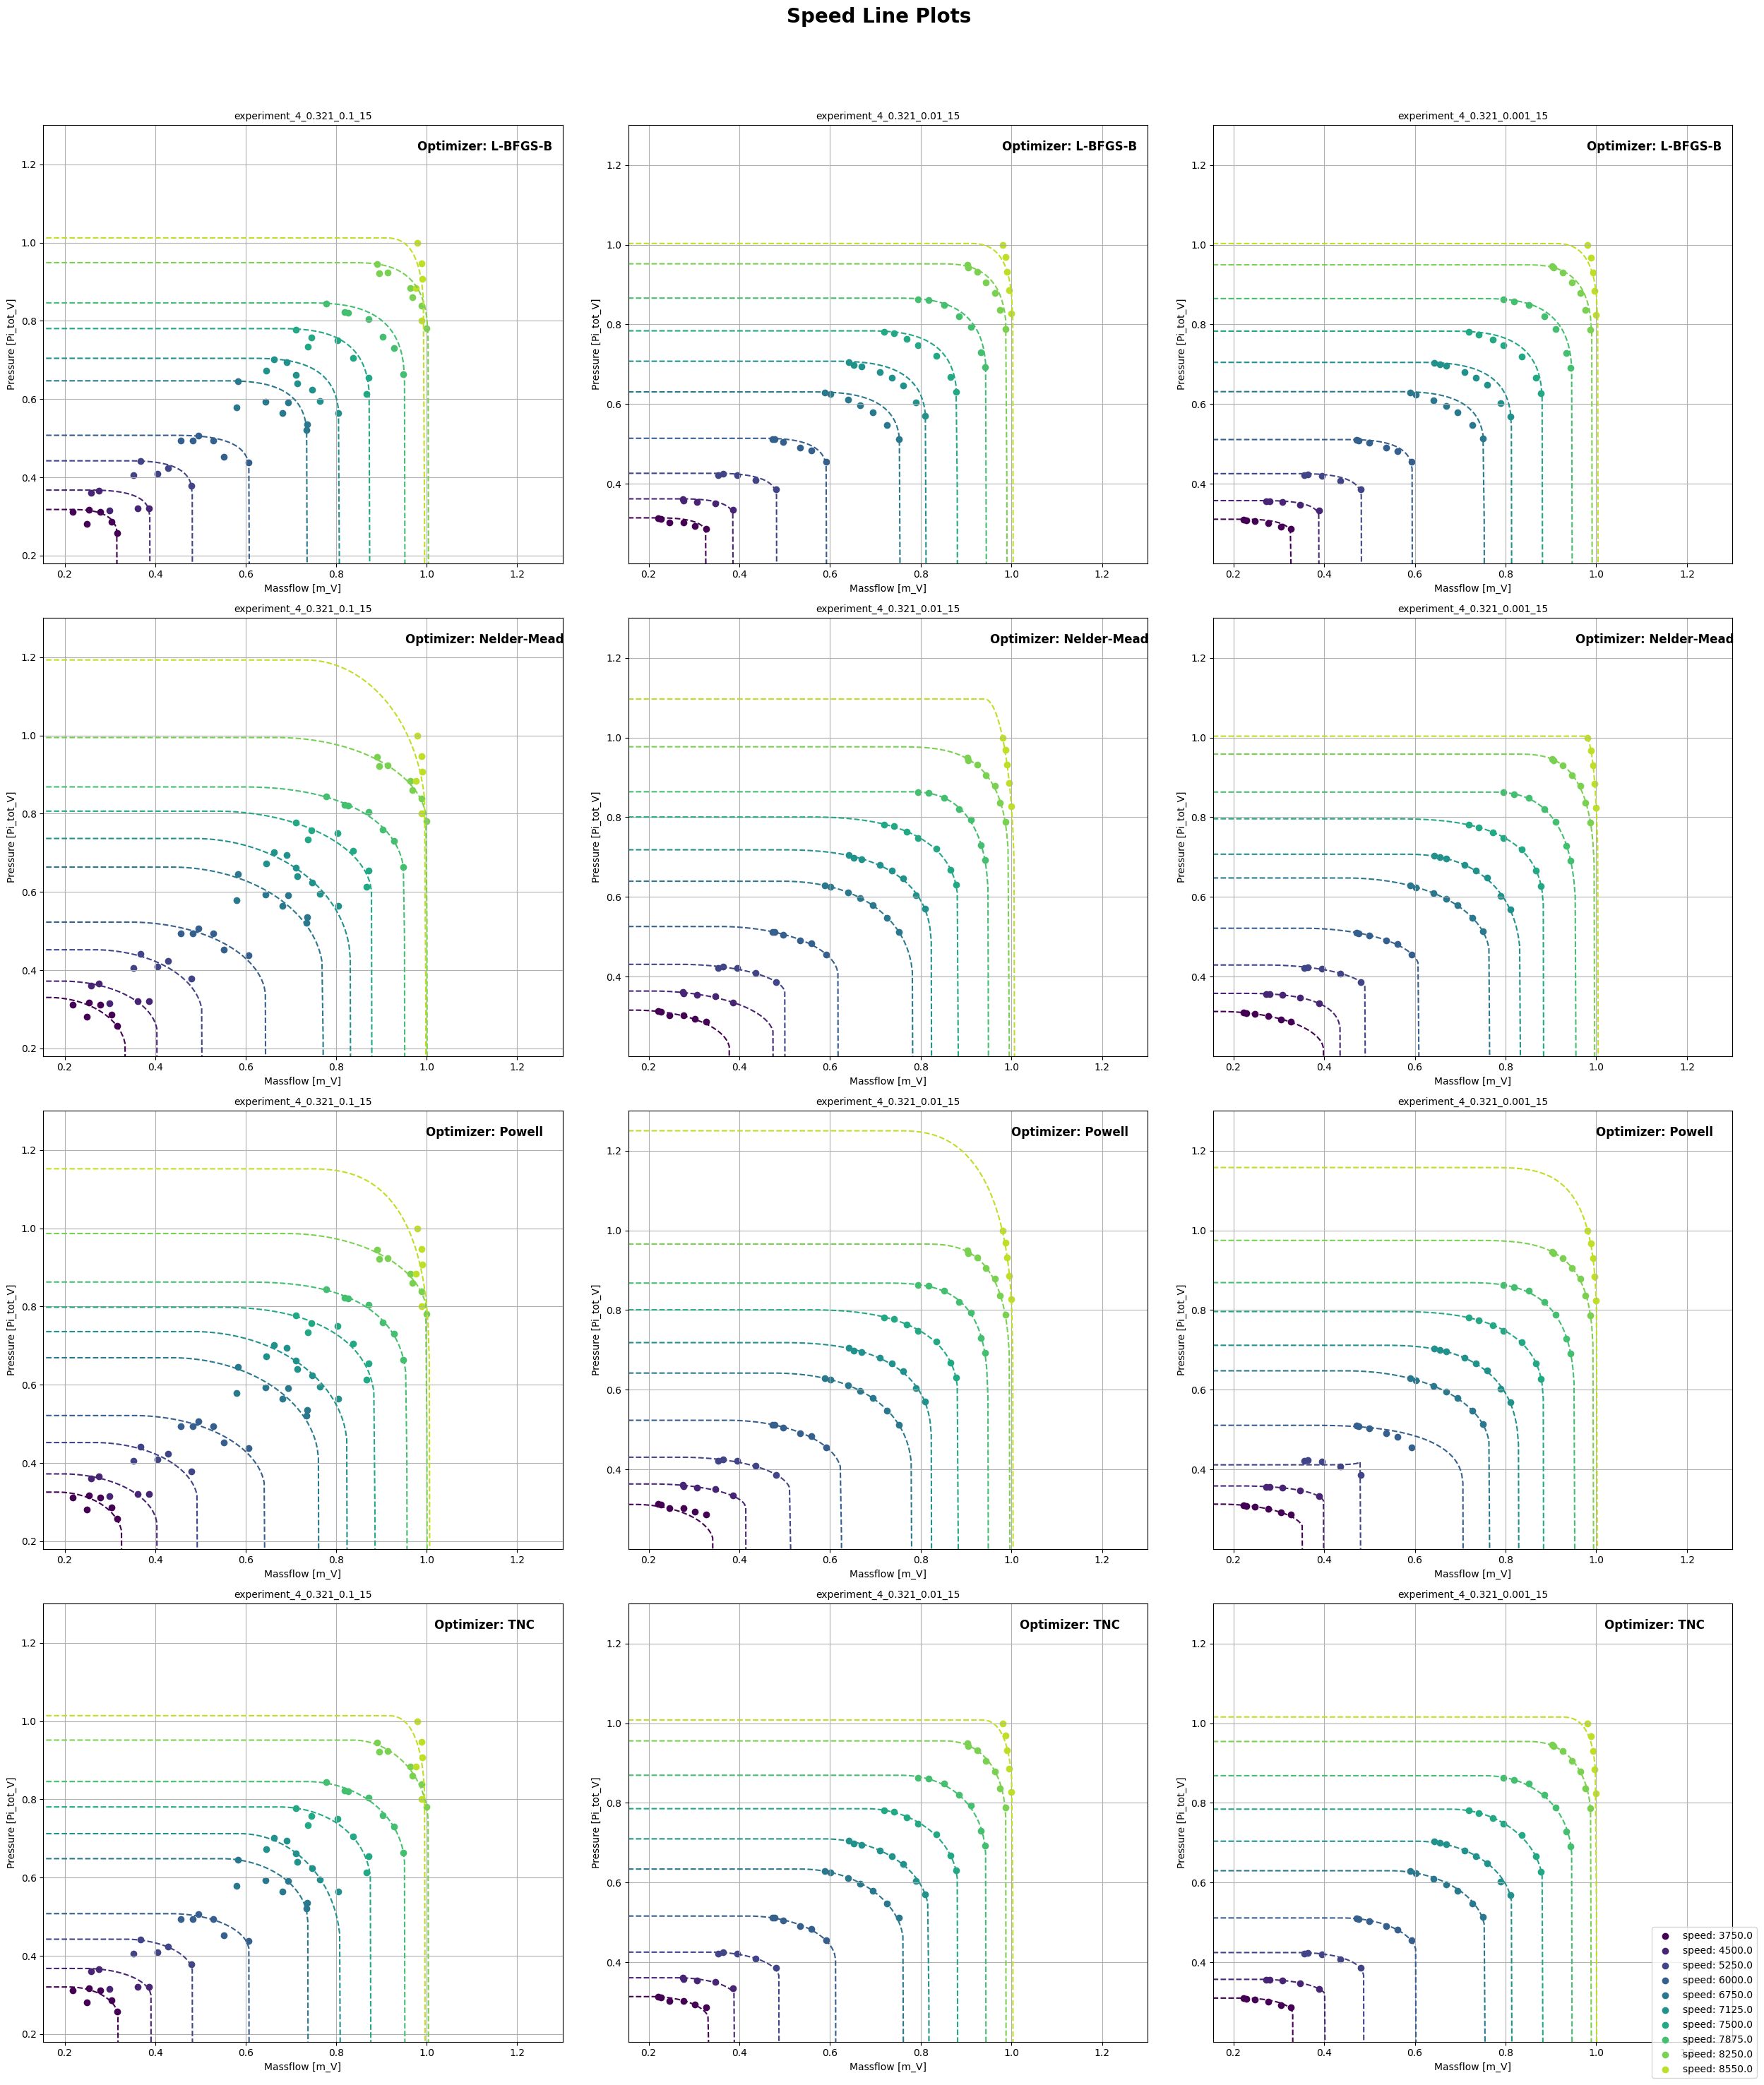

In [23]:
plot_sld(test_results_2)

plt.savefig('SpeedLinePlot-All-Optimizers-MAE', dpi = 200)

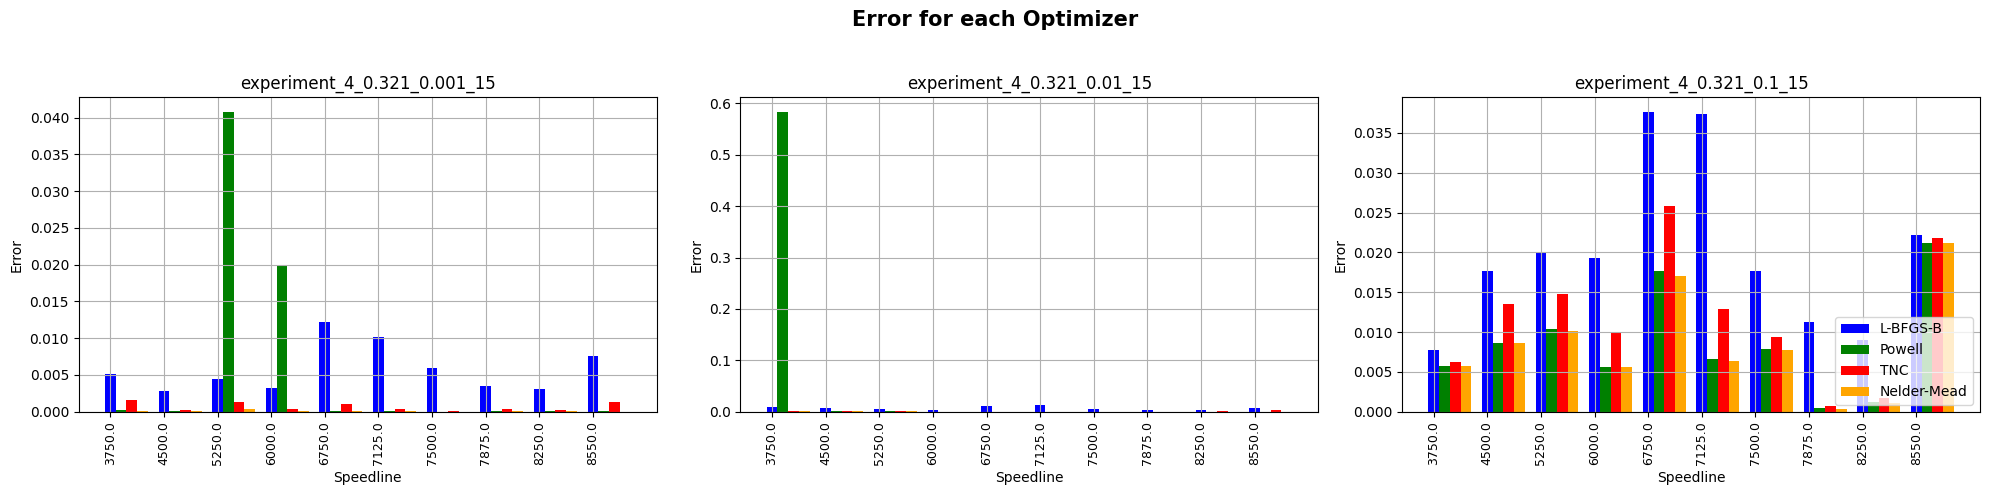

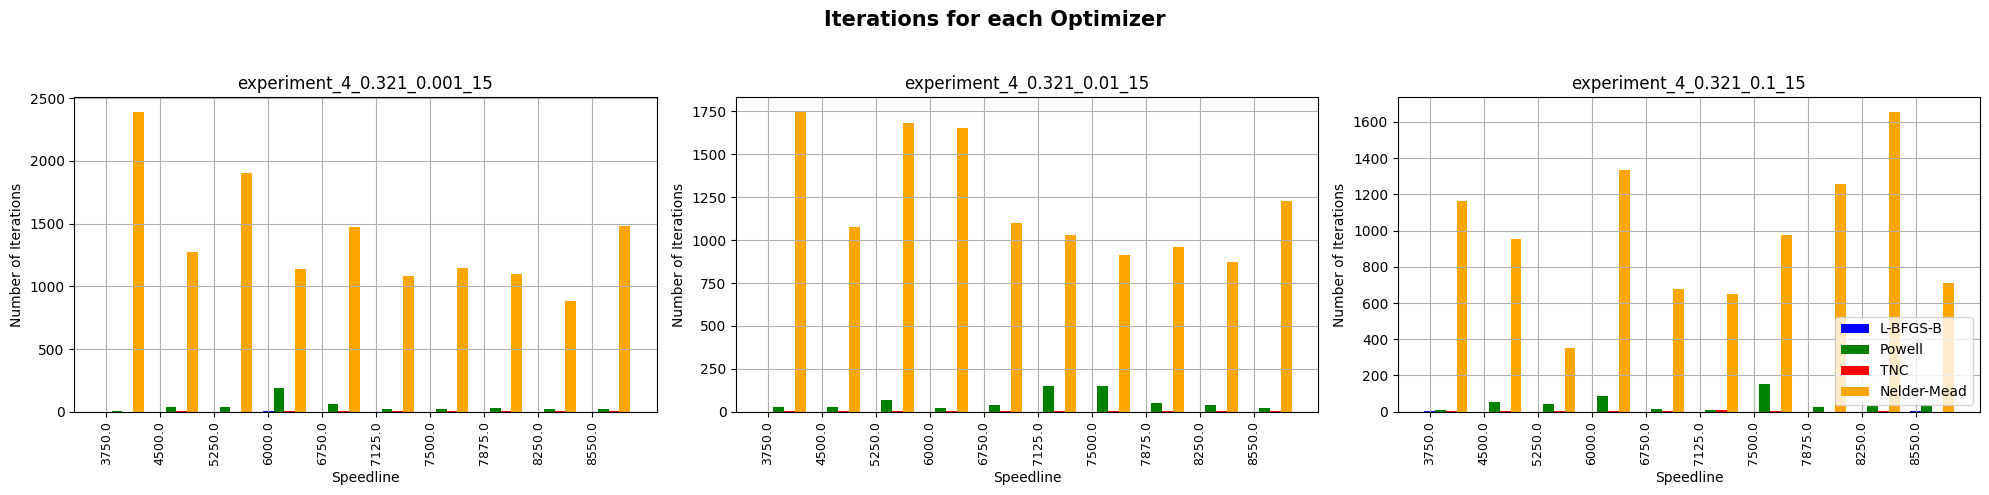

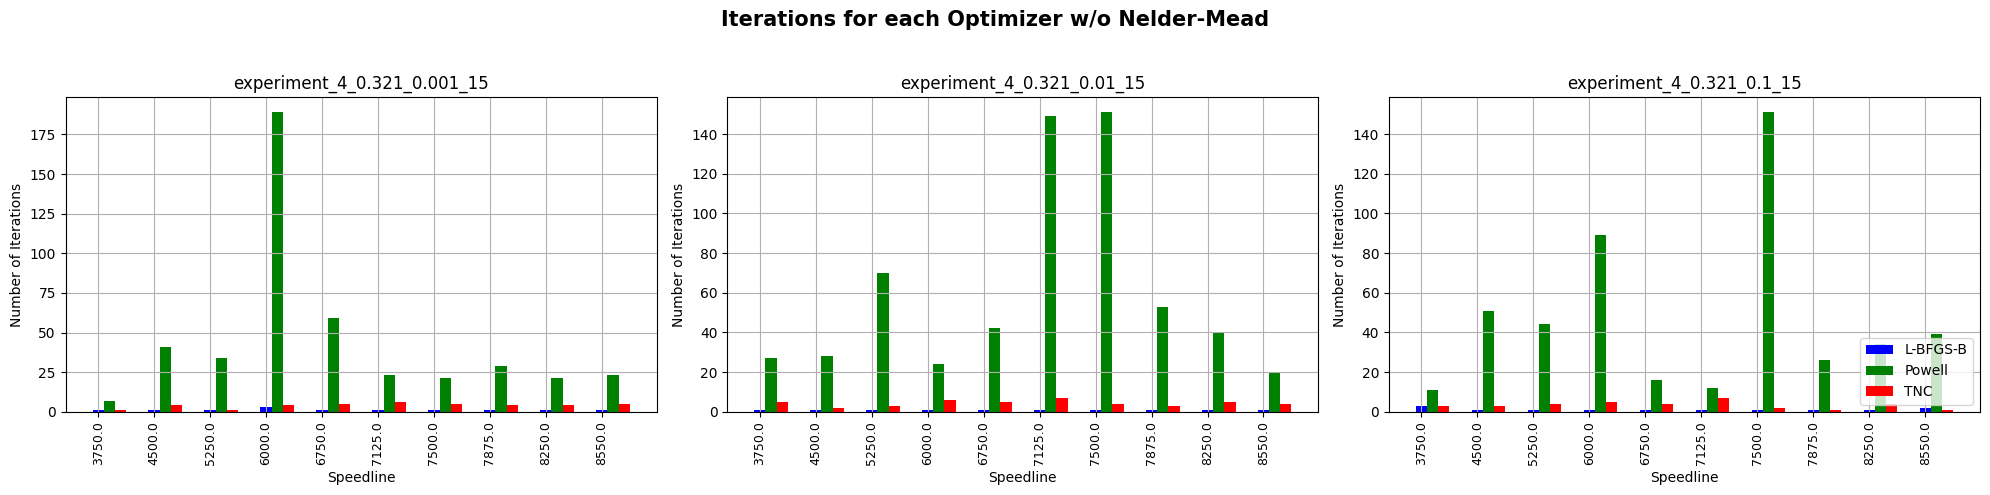

In [24]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results_2 = sorted(test_results_2, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results_2, 
          value = 'error', 
          ylabel = 'Error', 
          plot_title = 'Error for each Optimizer')
plot_eval(exp_sorted_results_2,
          value = 'niters', 
          ylabel = 'Number of Iterations', 
          plot_title = 'Iterations for each Optimizer', 
          is_nit = True,
          keep_nelder = True)
plot_eval(exp_sorted_results_2,
          value = 'niters', 
          ylabel = 'Number of Iterations', 
          plot_title = 'Iterations for each Optimizer w/o Nelder-Mead', 
          is_nit = True,
          keep_nelder = False)

## Error Metric - R2 Score

In [25]:
exp_data_list = ["experiment_4_0.321_0.1_15", 
                 "experiment_4_0.321_0.01_15",
                 "experiment_4_0.321_0.001_15"]

opt_method_list = ["L-BFGS-B",
                   "Powell",
                   "TNC",
                   "Nelder-Mead"]

# Get the cardinal product of the lists
data_opt_pairs = product(exp_data_list, opt_method_list)

In [26]:
test_results_1 = execute_optimization(data_opt_pairs, err_metric = "r2_score")

Using L-BFGS-B optimizer on experiment_4_0.321_0.1_15 data.

Using Powell optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.1_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: Op

Using Nelder-Mead optimizer on experiment_4_0.321_0.1_15 data.

Using L-BFGS-B optimizer on experiment_4_0.321_0.01_15 data.

Using Powell optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: Op

Using Nelder-Mead optimizer on experiment_4_0.321_0.01_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: ftol
  result = minimize(fun=residual_func,


Using L-BFGS-B optimizer on experiment_4_0.321_0.001_15 data.

Using Powell optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: RuntimeWarning: Method Powell does not use gradient information (jac).
  result = minimize(fun=residual_func,


Using TNC optimizer on experiment_4_0.321_0.001_15 data.



c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(fun=residual_func,
c:\Users\sonin\miniconda3\envs\spotpython\Lib\site-packages\spotoptim\fit\single_fit.py:388: Op

Using Nelder-Mead optimizer on experiment_4_0.321_0.001_15 data.



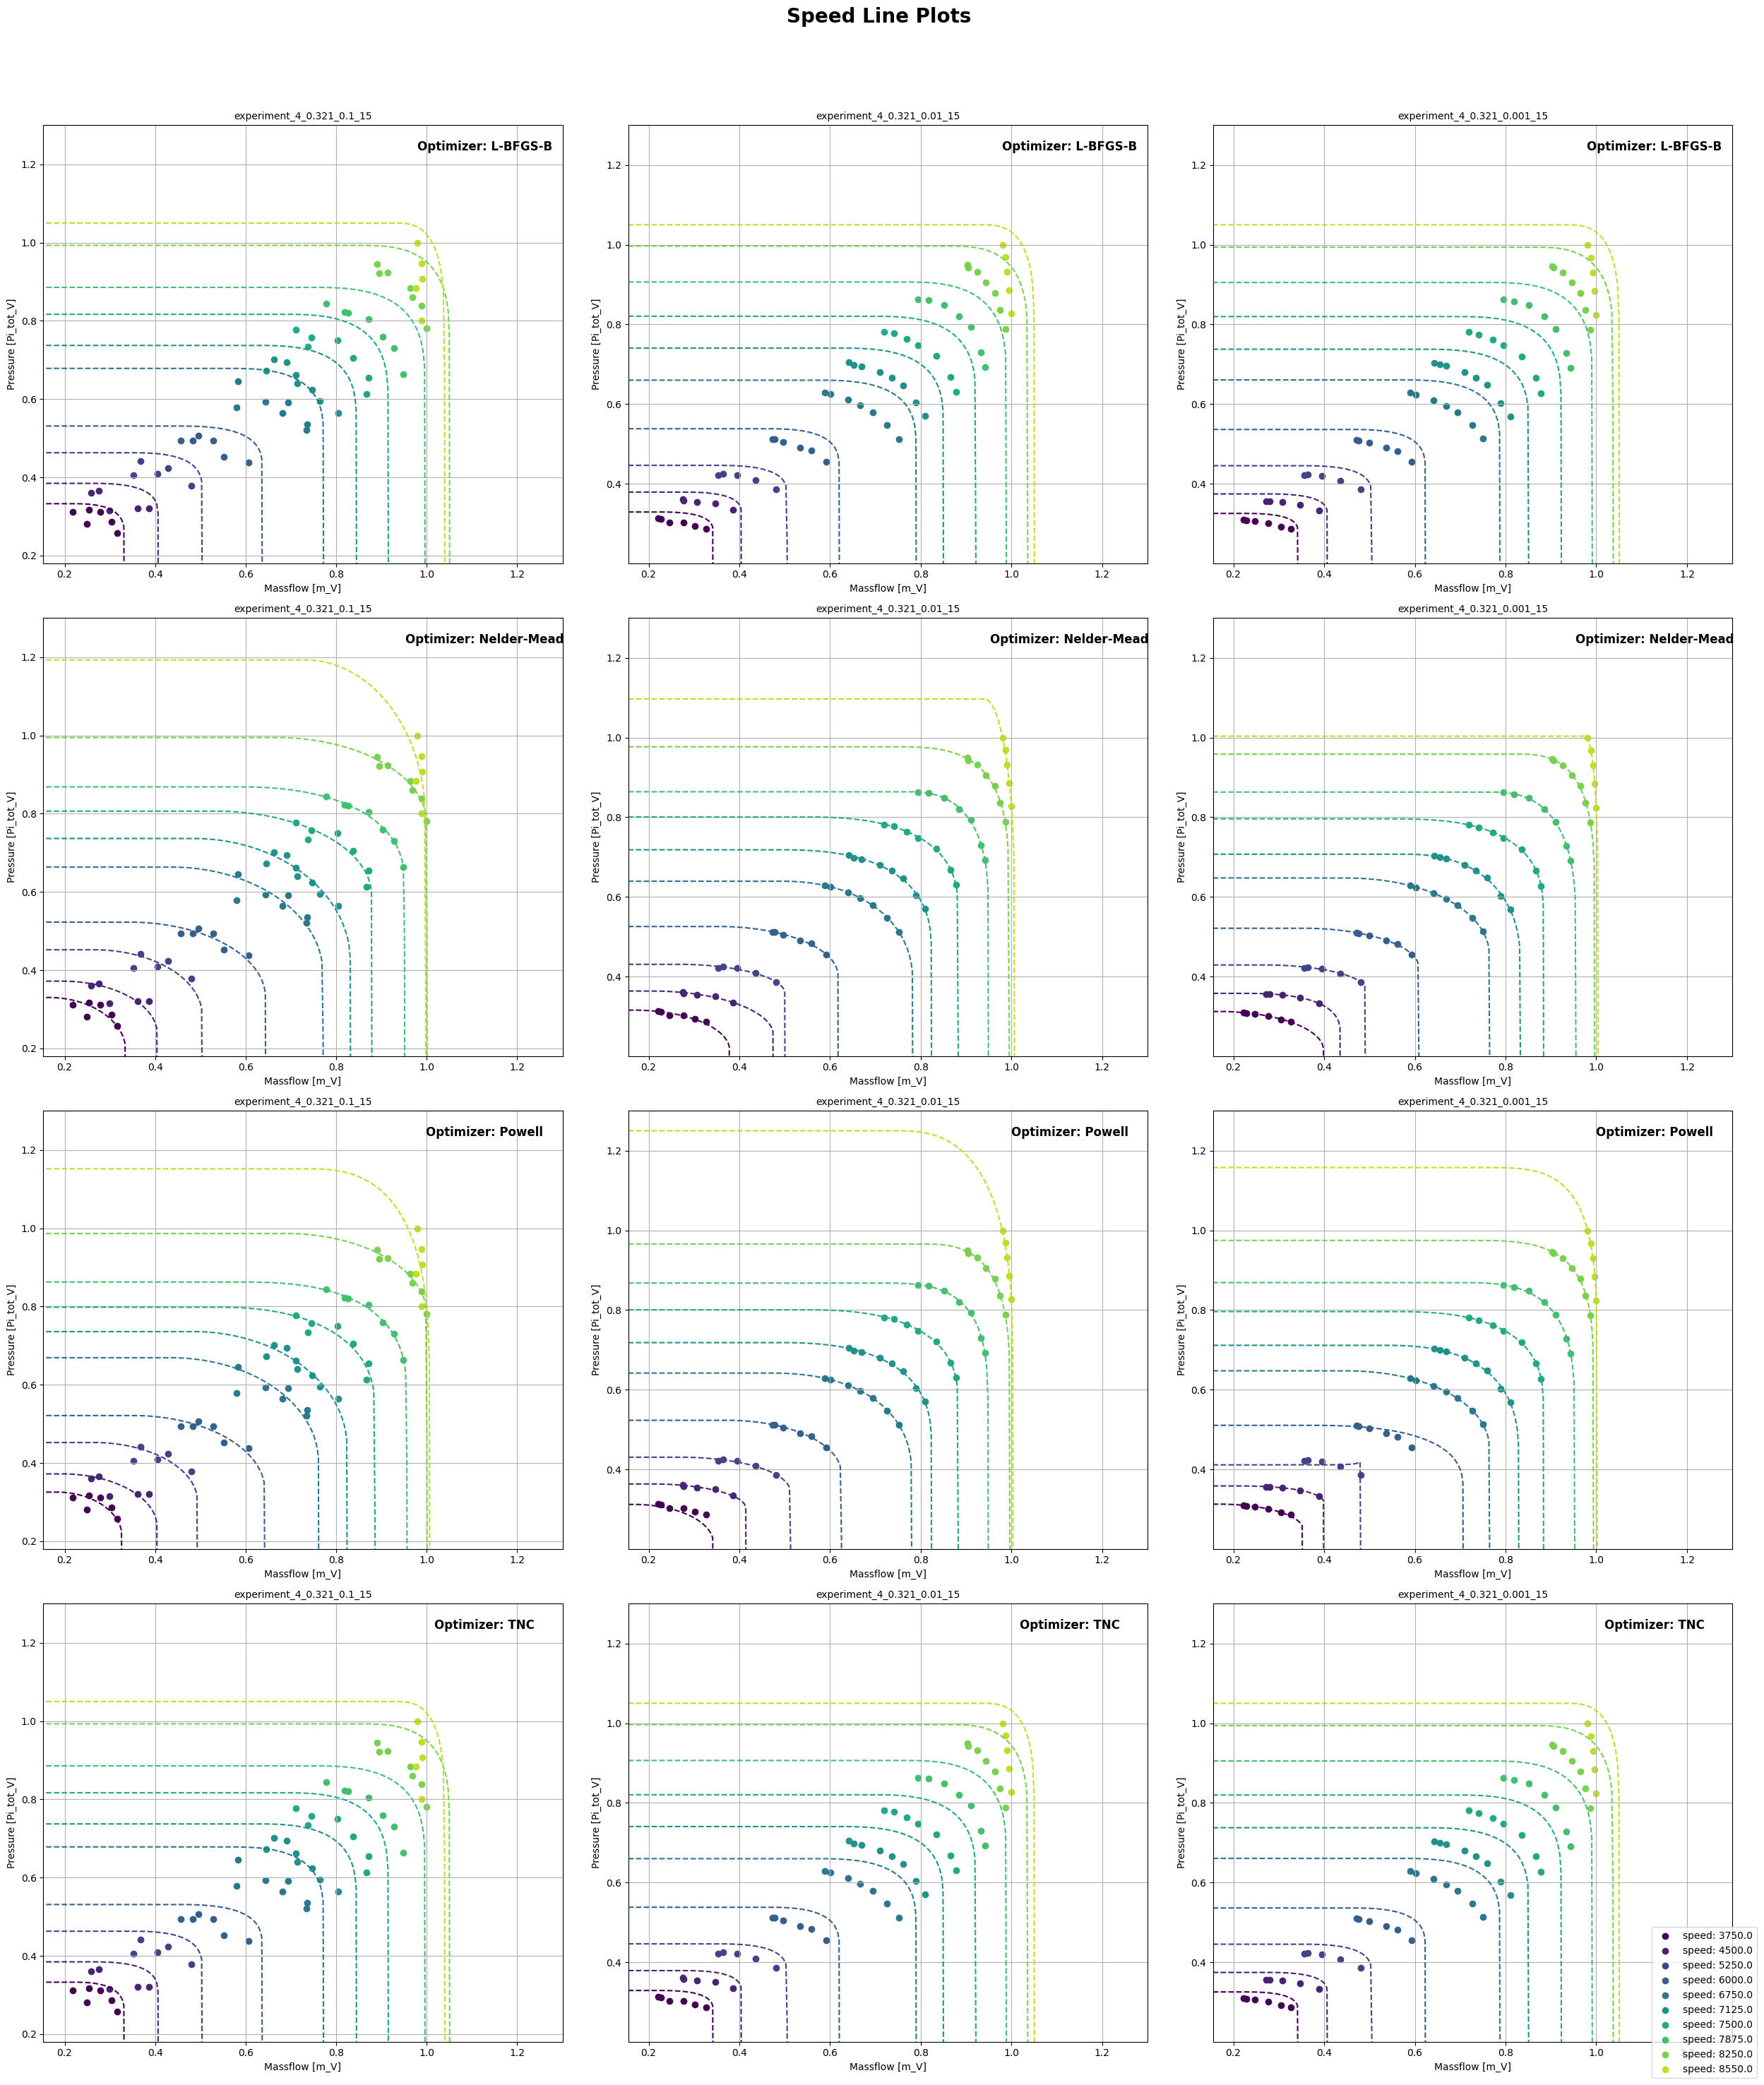

In [27]:
plot_sld(test_results_1)

plt.savefig('SpeedLinePlot-All-Optimizers-R2', dpi = 200)

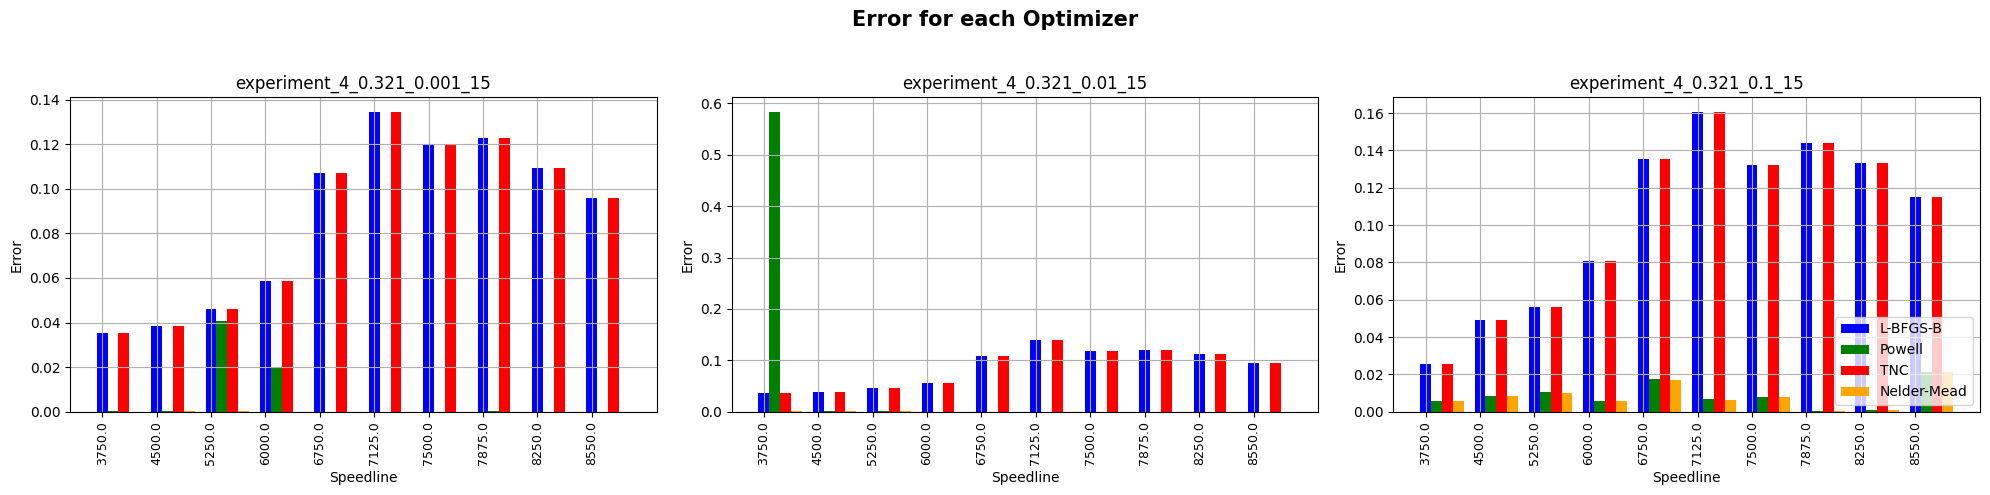

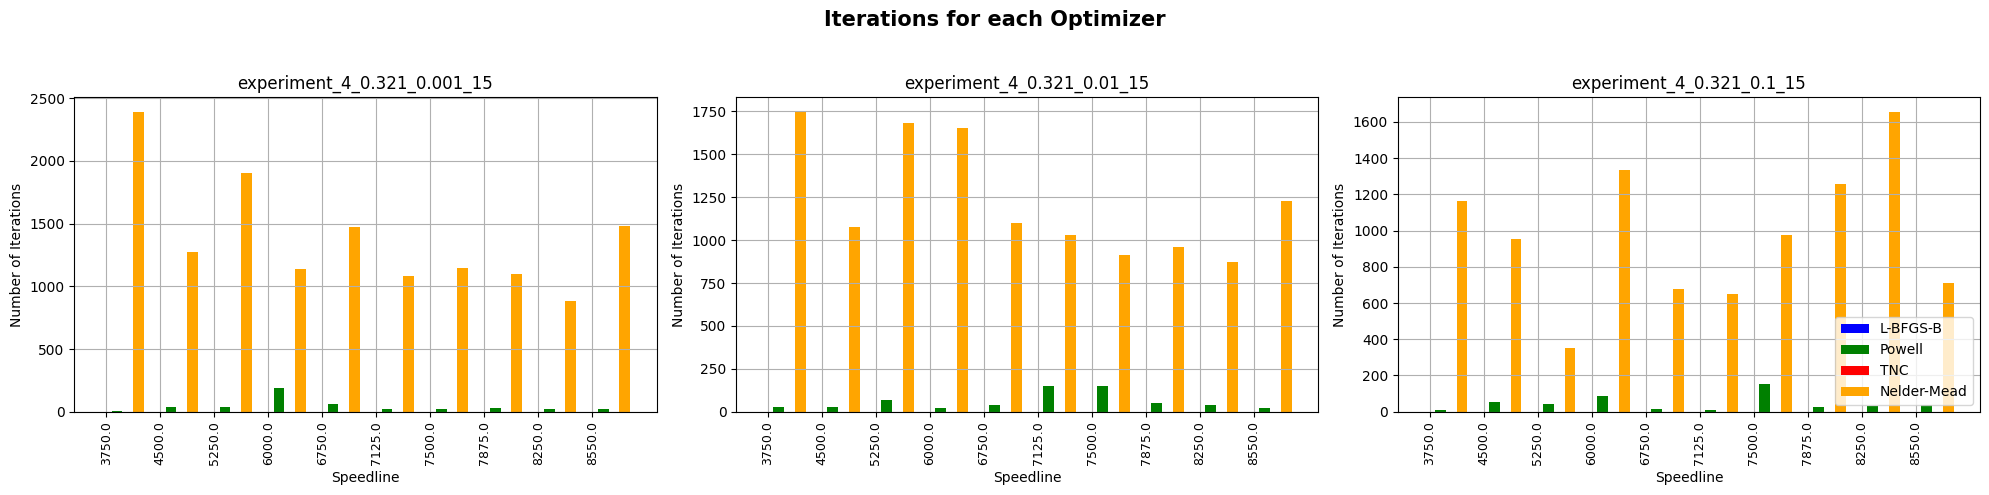

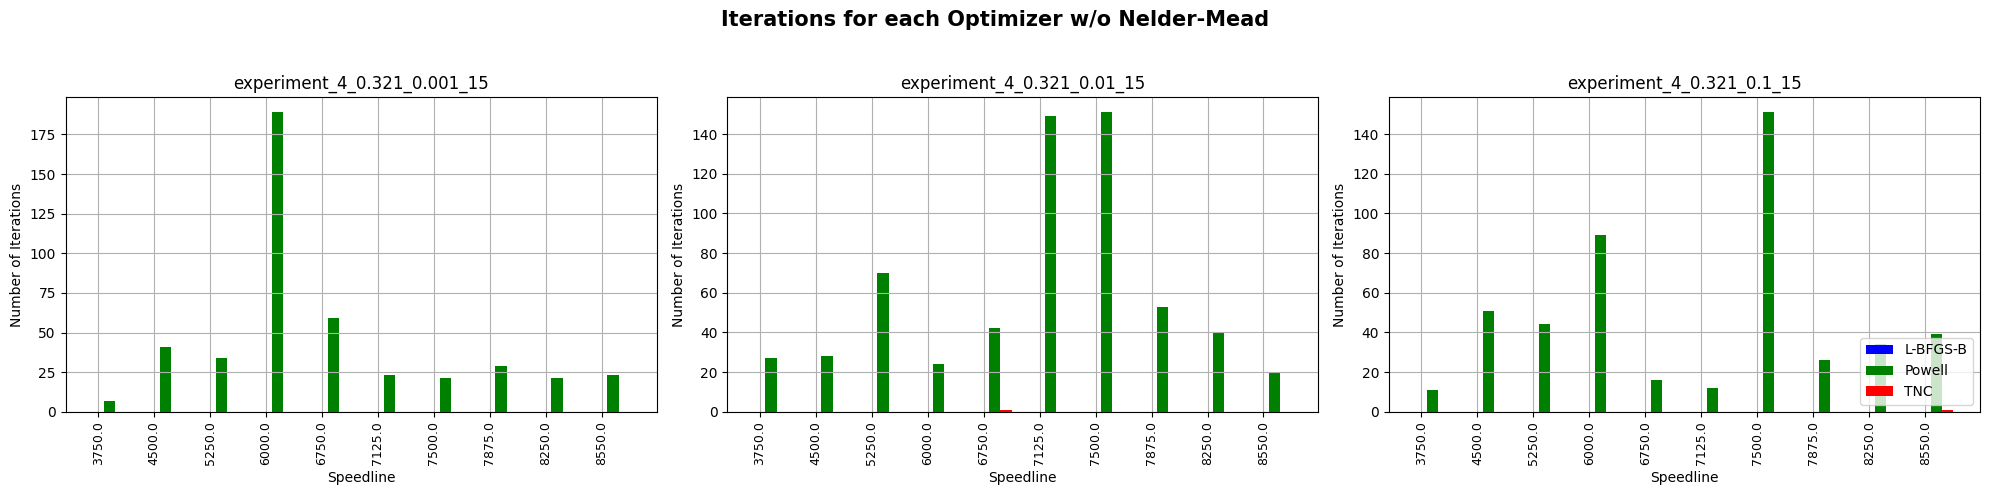

In [28]:
# Sort the list according to the datasets for plotting the graphs
exp_sorted_results_1 = sorted(test_results_1, key = itemgetter('experiment_data'))

plot_eval(exp_sorted_results_1, 
          value = 'error', 
          ylabel = 'Error', 
          plot_title = 'Error for each Optimizer')
plot_eval(exp_sorted_results_1,
          value = 'niters', 
          ylabel = 'Number of Iterations', 
          plot_title = 'Iterations for each Optimizer', 
          is_nit = True,
          keep_nelder = True)
plot_eval(exp_sorted_results_1,
          value = 'niters', 
          ylabel = 'Number of Iterations', 
          plot_title = 'Iterations for each Optimizer w/o Nelder-Mead', 
          is_nit = True,
          keep_nelder = False)

## Evaluation

### Overall Normalized RMSE value for both mass and pressure for all datasets

In [29]:
rmse_result = store_rmse_results(test_results, 'Ortho')
rmse_result_1 = store_rmse_results(test_results_1, 'R2')
rmse_result_2 = store_rmse_results(test_results_2, 'MAE')

combined_rmse_results = {}
for key, value in rmse_result.items():
    combined_rmse_results[key] = pd.concat([value, rmse_result_1[key], rmse_result_2[key]], ignore_index = True)

print("experiment_4_0.321_0.1_15")
print(tabulate(combined_rmse_results["experiment_4_0.321_0.1_15"], headers = 'keys', tablefmt = 'pretty'))
print("experiment_4_0.321_0.01_15")
print(tabulate(combined_rmse_results["experiment_4_0.321_0.01_15"], headers = 'keys', tablefmt = 'pretty'))
print("experiment_4_0.321_0.001_15")
print(tabulate(combined_rmse_results["experiment_4_0.321_0.001_15"], headers = 'keys', tablefmt = 'pretty'))

experiment_4_0.321_0.1_15
+----+-------------+--------------+----------------------------+-----------------------+
|    |  optimizer  | error_metric | overall_norm_rmse_Pi_tot_V | overall_norm_rmse_m_V |
+----+-------------+--------------+----------------------------+-----------------------+
| 0  |  L-BFGS-B   |    Ortho     |    0.025990969441785184    |  0.02696389397187962  |
| 1  |   Powell    |    Ortho     |    0.026450843248217632    |  0.02696683946150755  |
| 2  |     TNC     |    Ortho     |    0.02597854984389497     |  0.02702366864768158  |
| 3  | Nelder-Mead |    Ortho     |    0.02599097211655469     | 0.026963894312067294  |
| 4  |  L-BFGS-B   |      R2      |    0.08164266509203523     |  0.09102347722723726  |
| 5  |   Powell    |      R2      |    0.026450843248217632    |  0.02696683946150755  |
| 6  |     TNC     |      R2      |    0.08164266509203523     |  0.09102347722723726  |
| 7  | Nelder-Mead |      R2      |    0.02599097211655469     | 0.02696389431206729

In [30]:
dataset = combined_rmse_results["experiment_4_0.321_0.1_15"]

norm_rmse_Pi = dataset[['optimizer', 'error_metric', 'overall_norm_rmse_Pi_tot_V']]
norm_rmse_m = dataset[['optimizer', 'error_metric', 'overall_norm_rmse_m_V']]

### Sorting the configurations based on Overall RMSE value for both mass and pressure

In [31]:
norm_rmse_Pi = norm_rmse_Pi.sort_values(by = ['overall_norm_rmse_Pi_tot_V'])

print("Best Performers")
print(norm_rmse_Pi.head(5))
print("Worst Performers")
print(norm_rmse_Pi.tail(5))


Best Performers
      optimizer error_metric  overall_norm_rmse_Pi_tot_V
2           TNC        Ortho                    0.025979
0      L-BFGS-B        Ortho                    0.025991
3   Nelder-Mead        Ortho                    0.025991
7   Nelder-Mead           R2                    0.025991
11  Nelder-Mead          MAE                    0.025991
Worst Performers
   optimizer error_metric  overall_norm_rmse_Pi_tot_V
5     Powell           R2                    0.026451
10       TNC          MAE                    0.028859
8   L-BFGS-B          MAE                    0.034319
6        TNC           R2                    0.081643
4   L-BFGS-B           R2                    0.081643


In [32]:
norm_rmse_m = norm_rmse_m.sort_values(by = ['overall_norm_rmse_m_V'])

print("Best Performers")
print(norm_rmse_m.head(5))
print("Worst Performers")
print(norm_rmse_m.tail(5))

Best Performers
      optimizer error_metric  overall_norm_rmse_m_V
0      L-BFGS-B        Ortho               0.026964
3   Nelder-Mead        Ortho               0.026964
7   Nelder-Mead           R2               0.026964
11  Nelder-Mead          MAE               0.026964
5        Powell           R2               0.026967
Worst Performers
   optimizer error_metric  overall_norm_rmse_m_V
2        TNC        Ortho               0.027024
10       TNC          MAE               0.033060
8   L-BFGS-B          MAE               0.045661
6        TNC           R2               0.091023
4   L-BFGS-B           R2               0.091023


### Plotting two best and worst performing configurations

In [33]:
# Getting the top two performers and the worst performers
configs_to_plot = []
experiment_data = 'experiment_4_0.321_0.1_15'
optimizers = ["L-BFGS-B", "Nelder-Mead"]

for res in test_results:
    if res["experiment_data"] == experiment_data and res["optimizer"] in optimizers:
        configs_to_plot.append({
            "experiment_data": res["experiment_data"],
            "optimizer": res["optimizer"],
            "sld": res["sld"],
            "error_metric": "Ortho"
        })

optimizers = ["L-BFGS-B", "TNC"]

for res in test_results_1:
    if res["experiment_data"] == experiment_data and res["optimizer"] in optimizers:
        configs_to_plot.append({
            "experiment_data": res["experiment_data"],
            "optimizer": res["optimizer"],
            "sld": res["sld"],
            "error_metric": "R2"
        })

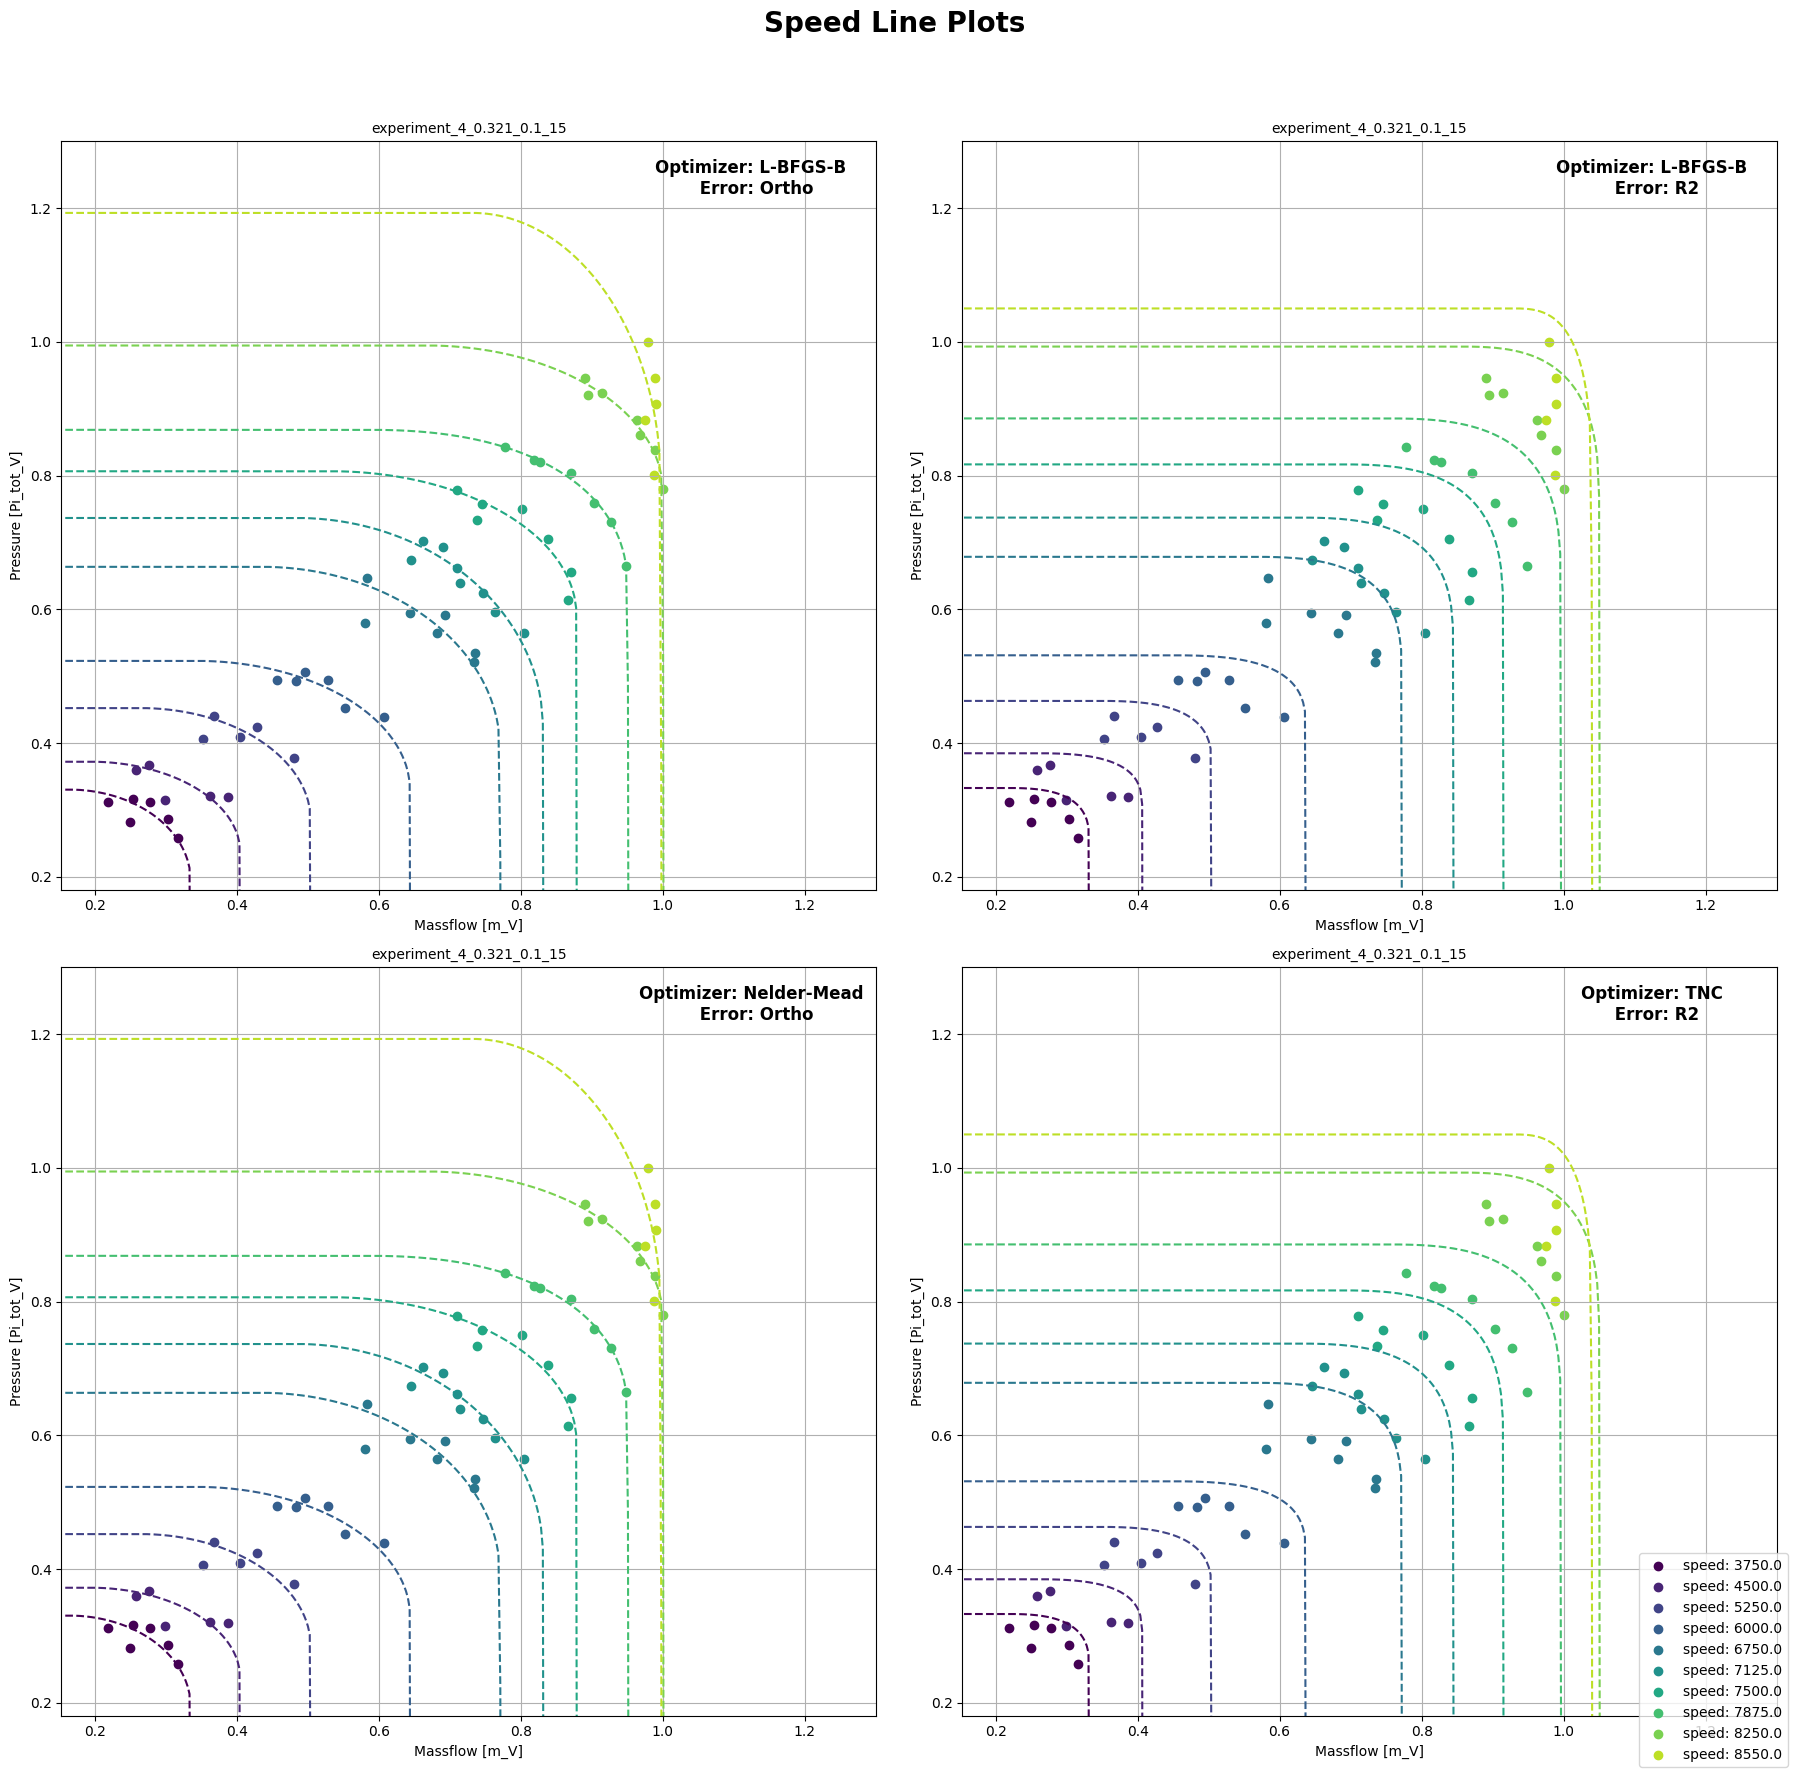

In [34]:
plot_sld(configs_to_plot, nrows = 2, ncols = 2, figsize = (18, 18))

## Saving Best Optimizer Results

In [36]:
res = execute_optimization([("experiment_4_0.321_0.1_15", "L-BFGS-B"),
                            ("experiment_4_0.321_0.01_15", "L-BFGS-B"),
                            ("experiment_4_0.321_0.001_15", "L-BFGS-B")], err_metric = "ortho")

Using L-BFGS-B optimizer on experiment_4_0.321_0.1_15 data.

Using L-BFGS-B optimizer on experiment_4_0.321_0.01_15 data.

Using L-BFGS-B optimizer on experiment_4_0.321_0.001_15 data.



### Storing optimal beta values for each speedline and each dataset

In [37]:
x_values = {}

for r in res:
    results = r['res']
    # x_values = {key: result["x"] for key, result in res.items()}

    x_val = {key:res["x"] for key,res in results.items()}

    x_values[r['experiment_data']] = x_val

# print(x_values)

# Convert to a dataframe
x_values_df = pd.DataFrame(x_values)
print(x_values_df)

x_values_df.to_csv('x_values.csv')


                                experiment_4_0.321_0.1_15  \
3750.0  [0.16399884228592926, 0.3303334897969338, 0.33...   
4500.0  [0.1934190870676227, 0.3720556975787439, 0.404...   
5250.0  [0.26397909032974615, 0.4522661003184271, 0.50...   
6000.0  [0.3429241743909716, 0.5228450240414464, 0.644...   
6750.0  [0.43509552174965, 0.6635393545518632, 0.77081...   
7125.0  [0.4845179385823335, 0.7365956312557226, 0.831...   
7500.0  [0.5328942926063809, 0.8064751798402142, 0.878...   
7875.0  [0.5832593135397903, 0.8684395415296433, 0.950...   
8250.0  [0.6678637071605705, 0.9945700731085308, 1.000...   
8550.0  [0.7315622778494716, 1.1928692606185927, 0.997...   

                               experiment_4_0.321_0.01_15  \
3750.0  [0.16628675843784968, 0.31558209368366025, 0.3...   
4500.0  [0.25222432091736513, 0.36152804494603785, 0.3...   
5250.0  [0.2653012797491775, 0.4305408850292587, 0.500...   
6000.0  [0.3545166371720328, 0.5255314154647438, 0.617...   
6750.0  [0.490298336514